In [1]:
import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from DataProcuring import Data
import torch.nn as nn
import torch
from torch import Tensor
from lampe.inference import NPE, NPELoss
from lampe.nn import ResMLP
from zuko.flows import MAF
import numpy as np
from tqdm import tqdm
from pathlib import Path
import os
import pandas as pd
from lampe.data import H5Dataset
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from DataProcuring import Data 
from ProcessingSpec import ProcessSpec
from spectra_simulator import make_pt, SpectrumMaker
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal

from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *


/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [2]:
class NPEWithEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding =  ResMLP(
                6144 , 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5,  #1291 #6144, 3072, 1536
                activation=nn.ELU,
            )
        
        self.npe = NPE(
            20, self.embedding.out_features,
            transforms=3,
            build=MAF,
            hidden_features=[512] * 5,
            activation= nn.ELU,
        )

    def forward(self, theta: Tensor, x: Tensor) -> Tensor:
        y = self.embedding(x)
        if torch.isnan(y).sum()>0:
             print('NaNs in embedding')
        return self.npe(theta, y)

    def flow(self, x: Tensor):  # -> Distribution
        out = self.npe.flow(self.embedding(x)) #.to(torch.double)) #
        # if np.any(np.isnan(out.detach().cpu().numpy())):
        #      print('NaNs in flow')
        return out

In [3]:
estimator = NPEWithEmbedding().double().cuda()

In [4]:
def noisy(x, b= None): #50 is 10% of the median of the means of spectra in the training set.
    bs = x.size()[0]
    data_uncertainty = Data().err * Data().flux_scaling
    data_uncertainty = torch.from_numpy(data_uncertainty).cuda()

    if b == None: 
        m = torch.distributions.log_normal.LogNormal(torch.tensor([1.5]), torch.tensor([0.5]))
        b = m.sample([bs])
    else: 
        b = torch.Tensor([b]).cuda()
    x = x + torch.mul(data_uncertainty * b.cuda() , torch.randn_like(x))

    return x, b

In [5]:
# obs_file = '/home/mvasist/Highres/observation/simulated_obs/x_sim_b.npy'
# obs = torch.from_numpy(np.loadtxt(obs_file))
# obs = obs[0]
# obs = torch.unsqueeze(obs, 0)
# x_star, _ =  noisy(obs.cuda())
# theta_star = torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/theta_sim_b.npy'))


In [6]:
# x_star.size()

In [7]:
# with torch.no_grad():
#     theta = torch.cat([estimator.flow(x_star[0].cuda()).sample((2**1,)).cpu() #**14
#                         for _ in tqdm(range(2**6))

#                 ])

In [8]:
# theta.size()

In [9]:
scratch = os.environ['SCRATCH']
epoch = 350
savepath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise'
runpath = savepath / 'peachy-feather-81'
savepath_plots = runpath  / ('plots_sim_b_' + str(epoch))
df_theta = pd.read_csv( savepath_plots / 'theta.csv')
theta = df_theta.values
theta = torch.from_numpy(theta)
print(theta)

tensor([[ 0.8589,  1.0318,  4.2882,  ..., 41.8271,  0.8744,  9.5382],
        [ 0.4455,  1.0285,  4.0504,  ..., 42.2316,  0.4966,  7.8440],
        [ 0.5179,  1.6547,  4.3155,  ..., 41.1872,  0.6004,  7.9455],
        ...,
        [ 0.8941,  1.5012,  3.9493,  ..., 44.1719,  0.8635,  4.7281],
        [ 1.6474,  1.2874,  4.5163,  ..., 44.7207,  0.8110, 12.9409],
        [ 0.8329,  1.4113,  4.5332,  ..., 43.7155,  0.8041,  6.7473]],
       dtype=torch.float64)


In [10]:
df_theta[:2**8]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.858871,1.031834,4.288240,1679.555569,819.863796,487.773153,1493.180465,1.247667,6.967672,2.596050,-1.864810,5.400847,8.067990,0.510313,-5.506611,1.421009,20.777585,41.827142,0.874353,9.538244
1,0.445470,1.028499,4.050431,2278.163956,887.826028,662.438235,2570.549903,1.455200,7.674865,0.902378,-0.317029,6.445385,10.498775,2.508125,-7.111570,1.315006,21.043703,42.231637,0.496631,7.844010
2,0.517874,1.654742,4.315497,1203.214902,737.686195,1466.674792,1259.165353,1.819995,5.774803,-0.795790,1.194480,3.648663,10.150760,2.273292,-5.441716,1.182504,20.764804,41.187214,0.600374,7.945534
3,0.826352,1.523203,3.983951,2028.397754,852.912081,508.038262,1390.834595,1.459566,7.350030,-2.891849,-0.385518,10.580159,10.220223,2.001084,-5.133943,1.425773,20.755203,45.224374,0.727166,13.655222
4,0.561853,0.918550,4.116199,1543.862294,347.294292,899.671869,3331.470751,1.242192,6.285499,1.265590,-0.970370,3.475678,8.804299,2.707145,-7.181125,1.313745,20.459255,41.245837,0.577247,5.121686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.527773,0.963444,4.185199,1558.189795,784.929850,522.513679,1707.874250,1.849921,6.394816,1.473320,-0.100177,10.061722,10.146322,2.509183,-2.906960,1.417594,20.869897,41.738677,0.304541,9.845842
252,0.960706,1.322099,4.221960,1596.240928,449.666999,421.414605,2208.925741,1.253446,6.565970,-0.813475,-0.828902,-0.108459,8.302638,2.230956,-7.729890,1.390269,20.466598,42.296999,1.159418,5.381450
253,0.283608,1.113035,3.938504,2578.383980,964.427140,870.319644,3347.311015,1.281821,8.002000,0.957230,0.962807,1.494650,5.645942,1.697120,-11.046900,1.320731,20.296039,43.601629,0.849676,7.960392
254,0.248125,1.615384,3.445186,1200.793520,790.570108,885.478759,1929.404971,1.913045,5.508538,3.329963,0.016927,6.724016,8.804535,2.694608,-6.545414,1.449178,20.519957,38.966402,0.463073,5.653898


In [11]:
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
[                  r'$b$',  1, 20.0], # PH3_mol_scale

])

In [ ]:
# len(theta_star)

In [13]:
def filter_limbdark_mask(theta):
    mask = theta[:,-2]<0
    mask += theta[:,-2]>1
    return mask 
def filter_logdelta_mask(theta):
    # mask = theta[:,8]<
    mask = theta[:,8]>8
    return mask 

# print(thetascalebackup(theta))
mask1 = filter_limbdark_mask(theta)
theta_filterLD = theta[~mask1]
mask2 = filter_logdelta_mask(theta_filterLD)
theta_filterLD = theta_filterLD[~mask2]

In [23]:
d = Data()
processing = ProcessSpec()

sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [15]:
# fig, ax = plt.subplots(figsize=(4,4))

# ##sim PT
# pressures = sim.atmosphere.press / 1e6
# val_act = deNormVal(theta_star.cpu().numpy(), param_list)
# params = param_set.param_dict(val_act)
# temp= make_pt(params , pressures)
# ax.plot(temp, pressures, color = 'black')  ##sim
# ##sim PT

# print(theta_filterLD[:2**8, :-1].size(), theta_filterLD)
# fig_pt = PT_plot(fig, ax, theta_filterLD[:2**8, :-1], invert = True) #, self.theta_star)
# # fig_pt = PT_plot(fig_pt, ax, self.theta_paul[:2**8], invert = True, color = 'orange') #, theta_star)
# # fig_pt.savefig(self.savepath_plots / 'pt_profile_Paul_unregPTwithb_24Apr2023.pdf')
# # fig_pt.savefig(savepath_plots / 'pt_profile.pdf')


In [16]:
# temperatures = []
# for i, th in enumerate(theta[:2**8]):
#     params = param_set.param_dict(th.numpy())
#     print(i, params, pressures) 
#     temperatures.append(make_pt(params , pressures)) 
    

In [17]:
# params = param_set.param_dict(theta[171].numpy())
# print(params) 
# params['log_delta'] = 7
# params

In [18]:
# t = make_pt(params , pressures)
# t

In [25]:
pressures = sim.atmosphere.press / 1e6
# pressures = torch.from_numpy(pressures)

In [26]:
def simulator(theta):  
    values_actual = theta[:-4].numpy()
    values_ext_actual = theta[-4:].numpy()
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))    
    return x.squeeze()

In [28]:
# ## Residuals
theta_filterLD_512 = theta_filterLD[:2**9]

for t in tqdm(theta_filterLD_512[:,:-1]):
    simulator(t)  #**9

 11%|█         | 54/512 [01:01<08:38,  1.13s/it]


KeyboardInterrupt: 

In [ ]:
x_filterLD_512 = x_filterLD_512[:,0]
mask = ~np.isnan(x_filterLD_512).any(axis=-1)
mask1 = ~np.isinf(x_filterLD_512[mask]).any(axis=-1)
theta_filterLD_512, x_filterLD_512 = theta_filterLD_512[mask][mask1], x_filterLD_512[mask][mask1]
x_filterLD_512 = torch.from_numpy(x_filterLD_512)
x_filterLD_512, _= noisy(x_filterLD_512.cuda(), theta_filterLD_512[:, -1])
# x_filterLD_512, _= noisy(x_filterLD_512.cuda(), theta_filterLD_512[:, -1])

df_theta = pd.DataFrame(theta_filterLD_512) #convert to a dataframe
df_x = pd.DataFrame(x_filterLD_512.cpu()) #convert to a dataframe

df_theta.to_csv('theta_256_noisy.csv',index=False) #save to file
df_x.to_csv('x_256_noisy.csv',index=False) #save to file

#Then, to reload:
df_theta = pd.read_csv('theta_256_noisy.csv')
theta_256_noisy = df_theta.values
df_x = pd.read_csv('x_256_noisy.csv')
x = df_x.values
theta_256_noisy, x_256_noisy = torch.from_numpy(theta_256_noisy), torch.from_numpy(x)

res_fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), gridspec_kw={'height_ratios': [3, 1]})
creds= [0.997, 0.955, 0.683]
alpha = (0.0, 0.9)
levels, creds = levels_and_creds(creds= creds, alpha = alpha)
cmap= LinearAlphaColormap('steelblue', levels=creds, alpha=alpha)

wlength = d.data_wavelengths

for q, l in zip(creds[:-1], levels):
    lower, upper = np.quantile(x_256_noisy.numpy(), [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax1.fill_between(wlength, lower, upper, color= cmap(l), linewidth=0) #'C0', alpha=0.4,

lines = ax1.plot(wlength, x_star.cpu(), color='black', label = r'$ f(\theta_{obs})$', linewidth = 0.4)
handles, texts = legends(axes= ax1, alpha=alpha) #0.15, 0.75
texts = [r'$ f(\theta_{obs})$', r'$p_{\phi}(f(\theta)|x_{obs})$']

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel(r'Planet flux $F_\nu$ (10$^{-5}$) Jy', fontsize = 10)
ax1.legend(handles, texts, prop = {'size': 8}, bbox_to_anchor=(1,1))

residuals = (x_256_noisy - x_star.cpu()) / torch.Tensor(d.err*d.flux_scaling*config['noise_scaling'])

for q, l in zip(creds[:-1], levels):
    lower, upper = np.quantile(residuals, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax2.fill_between(wlength, lower, upper, color= cmap(l) , linewidth=0) 
ax2.set_ylabel(r'Residuals', fontsize = 10)
ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)
# res_fig.savefig(savepath_plots / 'consistency_noisy.pdf')

In [58]:
datapath = Path(scratch) / 'highres-sbi/data_nic5'
trainset = H5Dataset(datapath / 'train.h5', batch_size=16, shuffle=True)


In [59]:
for t, x in trainset:
    print(t,x)
    break

tensor([[ 8.8268e-01,  5.1721e-01,  4.3213e+00,  2.2560e+03,  4.9818e+02,
          2.9671e+03,  1.3051e+03,  1.7393e+00,  4.9812e+00, -4.7309e+00,
          9.8314e-01,  1.7718e+00,  8.2863e+00,  1.1298e+00, -9.6537e+00,
          8.5653e-01,  2.4944e+01,  3.0002e+01,  3.9499e-01],
        [-1.2677e+00,  9.2835e-01,  3.9576e+00,  1.4625e+03,  5.7973e+02,
          2.6905e+03,  3.1949e+03,  1.4966e+00,  4.2317e+00, -2.3846e+00,
         -1.3922e+00,  1.6745e+00,  6.4616e+00,  2.7672e+00, -3.5578e+00,
          1.2066e+00,  2.5878e+01,  1.7026e+00,  7.2929e-01],
        [ 1.4029e-01,  1.4879e-01,  2.8178e+00,  2.5496e+03,  4.5446e+02,
          1.2257e+03,  2.3147e+03,  1.9859e+00,  5.1018e+00, -3.5435e+00,
         -1.0715e+00,  3.8199e+00,  1.2454e+01,  1.9963e+00, -8.6347e+00,
          1.4502e+00,  1.0656e+01,  2.5588e+01,  3.6525e-01],
        [-9.6293e-01,  8.3385e-01,  3.6448e+00,  3.4973e+02,  2.5755e+03,
          2.1616e+03,  2.3135e+03,  1.7835e+00,  3.9794e+00, -4.9330e+00,


In [60]:
t[0]

tensor([ 8.8268e-01,  5.1721e-01,  4.3213e+00,  2.2560e+03,  4.9818e+02,
         2.9671e+03,  1.3051e+03,  1.7393e+00,  4.9812e+00, -4.7309e+00,
         9.8314e-01,  1.7718e+00,  8.2863e+00,  1.1298e+00, -9.6537e+00,
         8.5653e-01,  2.4944e+01,  3.0002e+01,  3.9499e-01])

here i am
  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



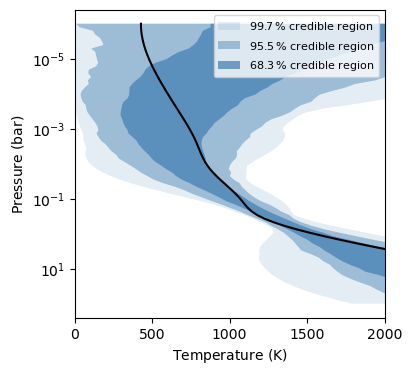

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import wandb

from dawgz import job, after, ensure, schedule
from itertools import chain, islice
from pathlib import Path
from torch import Tensor
from tqdm import tqdm
from typing import *
import pandas as pd

from lampe.data import H5Dataset
from zuko.distributions import BoxUniform
from lampe.inference import NPE, NPELoss
from lampe.nn import ResMLP
from zuko.flows import NAF, NSF, MAF, NCSF, SOSPF, UNAF, CNF 
from lampe.plots import nice_rc, corner, coverage_plot, mark_point
from lampe.utils import GDStep

import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from spectra_simulator import make_pt, SpectrumMaker
from DataProcuring import Data 
from ProcessingSpec import ProcessSpec
from parameter import *
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal

print('here i am')

# sys.path.insert(0, '/home/mvasist/Highres/sbi/added_scripts/')
from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *


# from ees import Simulator, LOWER, UPPER, LABELS, pt_profile
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
[                  r'$b$',  1, 20.0], # PH3_mol_scale

])

scratch = os.environ['SCRATCH']
datapath = Path(scratch) / 'highres-sbi/data_nic5'
savepath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise'

processing = ProcessSpec()
d = Data()
sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)


def simulator(theta):
    values_actual = theta[:-4].numpy()
    values_ext_actual = theta[-4:].numpy()
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))    
    return x.squeeze()


## Loading from a model to plot
CONFIGS = {
    'embedding': ['shallow'],
    'flow': ['MAF'],  #, 'NCSF', 'SOSPF', 'UNAF', 'CNF'], #'NAF', 
    'transforms': [3], #, 7], #3, 
    # 'signal': [16, 32],  # not important- the autoregression network output , 32
    'hidden_features': [512], # hidden layers of the autoregression network , 256, 
    'hidden_features_no' : [5], 
    'activation': [nn.ELU], #, nn.ReLU],
    'optimizer': ['AdamW'],
    'init_lr':  [1e-3], #[5e-4, 1e-5]
    'weight_decay': [1e-4], #[1e-4], #
    'scheduler': ['ReduceLROnPlateau'], #, 'CosineAnnealingLR'],
    'min_lr': [1e-5], # 1e-6
    'patience': [16], #8
    'epochs': [350],
    'stop_criterion': ['early'], #, 'late'],
    'batch_size':  [256],
    'spectral_length' : [6144], #[1536, 3072, 6144]
    'factor' : [0.3], 
    'noise_scaling' : [2], 
    'noise' : ['lognormaldist']
    # 'SOSF_degree' : [2,3,4],
    # 'SOSF_poly' : [2,4,6],
}


def experiment():
    # Config
    config = {
        key: random.choice(values)
        for key, values in CONFIGS.items()
    }

    def noisy(x, b= None): #50 is 10% of the median of the means of spectra in the training set.
        bs = x.size()[0]
        data_uncertainty = Data().err * Data().flux_scaling
        data_uncertainty = torch.from_numpy(data_uncertainty).cuda()

        if b == None: 
            if config['noise'] == 'uniformdist' :
                b = 1  + torch.rand(bs) * (10-1)
                b = torch.unsqueeze(b,1)
            elif config['noise'] == 'lognormaldist' :
                m = torch.distributions.log_normal.LogNormal(torch.tensor([1.5]), torch.tensor([0.5]))
                b = m.sample([bs])
        else: 
            b = torch.unsqueeze(b, 1)
            print(b.size())

        x = x + torch.mul(data_uncertainty * b.cuda() , torch.randn_like(x))
        return x, b

    class NPEWithEmbedding(nn.Module):
        def __init__(self):
            super().__init__()

            # Estimator
            if config['embedding'] == 'shallow':
                self.embedding = ResMLP(6144, 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5, activation= nn.ELU)
            else:
                self.embedding = ResMLP(6144, 128, hidden_features=[512] * 3 + [256] * 5 + [128] * 7, activation= nn.ELU)
            
            if config['flow'] == 'MAF':
                self.npe = NPE(
                    20, self.embedding.out_features,
                    # moments=((l + u) / 2, (l - u) / 2),
                    transforms=config['transforms'],
                    build=MAF,
                    # bins=config['signal'],
                    hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                    activation=config['activation'],
                )

        # def forward(self, theta: Tensor, x: Tensor) -> Tensor:
        def forward(self, theta, x): # -> Tensor:
            y = self.embedding(x)
            return self.npe(theta, y)

        # def flow(self, x: Tensor):  # -> Distribution
        def flow(self, x):  # -> Distribution
            out = self.npe.flow(self.embedding(x)) #.to(torch.double)) #
            return out

    if (config['flow'] == 'SOSPF') | (config['flow'] == 'UNAF'):
        estimator = NPEWithEmbedding().cuda()
    
    estimator = NPEWithEmbedding().double().cuda()

    def pipeout(theta , x):
        theta, x = theta.cuda(), x.cuda()
        x , b = noisy(x)
        theta = torch.hstack((theta, b.cuda()))
        return theta, x

    m = 'peachy-feather-81' #'comfy-dawn-59'
    epoch = config['epochs']
    runpath = savepath / m
    runpath.mkdir(parents=True, exist_ok=True)
    
    estimator = NPEWithEmbedding().double()
    states = torch.load(runpath / ('states_' + str(epoch) + '.pth'), map_location='cpu')
    estimator.load_state_dict(states['estimator'])
    estimator.cuda().eval()

############################################################
        
    savepath_plots = runpath  / ('plots_sim_b_' + str(epoch))
    savepath_plots.mkdir(parents=True, exist_ok=True)

    def thetascalebackup(theta):
        theta[:-1] =  torch.Tensor(LOWER[:-1]) + theta[:-1] * (torch.Tensor(UPPER[:-1]) - torch.Tensor(LOWER[:-1]))
        return theta

# #     ## Corner    
    obs = torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/x_sim_b.npy'))
    theta_star = torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/theta_sim_b.npy'))
    obs = torch.unsqueeze(obs[0], 0)
    theta_star = torch.unsqueeze(theta_star, 0)
    theta_star, x_star = pipeout(theta_star, obs)  #[1,6144] dimensions [1,20]
    theta_star, x_star = theta_star[0], x_star[0]
    
    #Then, to reload:
    df_theta = pd.read_csv( savepath_plots / 'theta.csv')
    theta = df_theta.values
    theta = torch.from_numpy(theta)

#     ## NumPy
    def filter_limbdark_mask(theta):
        mask = theta[:,-2]<0
        mask += theta[:,-2]>1
        return mask 
    def filter_logdelta_mask(theta):
        mask = theta[:,8]>8
        return mask 

    mask1 = filter_limbdark_mask(theta)
    theta_filterLD = theta[~mask1]
    mask2 = filter_logdelta_mask(theta_filterLD)
    theta_filterLD = theta_filterLD[~mask2]

    ### PT profile
    fig, ax = plt.subplots(figsize=(4,4))

    ##sim PT
    pressures = sim.atmosphere.press / 1e6
    val_act = deNormVal(theta_star.cpu().numpy(), param_list)
    params = param_set.param_dict(val_act)
    temp= make_pt(params , pressures)
    ax.plot(temp, pressures, color = 'black')  ##sim
    ##sim PT

    # print(theta_filterLD[:2**8, :-1].size(), theta_filterLD)
    fig_pt = PT_plot(fig, ax, theta_filterLD[:2**8, :-1], invert = True) #, self.theta_star)
    # fig_pt = PT_plot(fig_pt, ax, self.theta_paul[:2**8], invert = True, color = 'orange') #, theta_star)
    # fig_pt.savefig(self.savepath_plots / 'pt_profile_Paul_unregPTwithb_24Apr2023.pdf')
    # fig_pt.savefig(savepath_plots / 'pt_profile.pdf')


experiment()
